In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import torch.nn.functional as F

d:\Download\Applications\anaconda\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
d:\Download\Applications\anaconda\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
C:\Users\Admin\AppData\Local\Temp/ipykernel_1440/3083361920.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df_ab = pd.read_csv('ptbdb_abnormal.csv', header = None)
df_no = pd.read_csv('ptbdb_normal.csv', header=None)

In [3]:
ab_ = df_ab.values[:, :187]
no_ = df_no.values[:, :187]

In [4]:
print(len(ab_), len(no_))

10506 4046


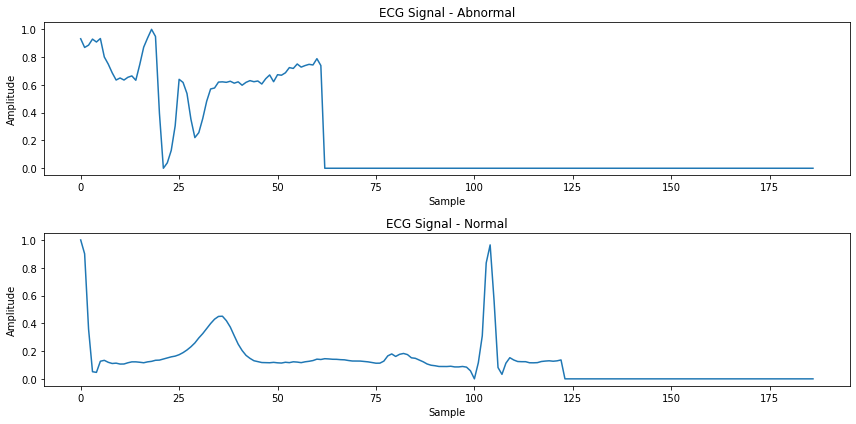

In [5]:
#Visualize one signal from both classes
sample_ab = ab_[0]
sample_no = no_[0]
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)  # Subplot 1
plt.plot(sample_ab)
plt.title('ECG Signal - Abnormal')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)  # Subplot 2
plt.plot(sample_no)
plt.title('ECG Signal - Normal')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

<Figure size 1080x720 with 0 Axes>

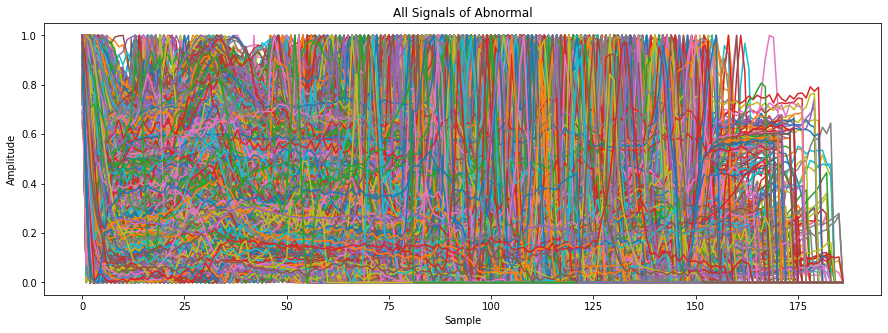

In [18]:
plt.figure(figsize=(15, 10))

plt.figure(figsize=(15, 5))

for i in range(len(ab_)):
    plt.plot(ab_[i], label=f'Signal {i+1}')

plt.title('All Signals of Abnormal')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
#plt.legend()
plt.show()

<Figure size 1080x720 with 0 Axes>

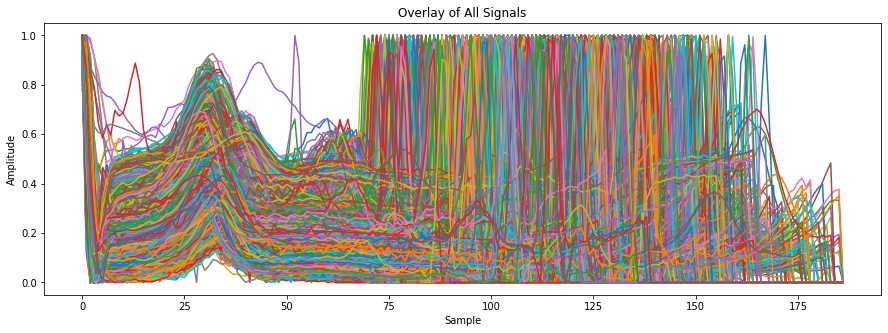

In [7]:
plt.figure(figsize=(15, 10))

plt.figure(figsize=(15, 5))

for i in range(len(no_)):
    plt.plot(no_[i], label=f'Signal {i+1}')

plt.title('All Signals of Normal')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
#plt.legend()
plt.show()

In [8]:
df_ab_sampled = df_ab.sample(n=5000, random_state=42)
df = pd.concat([df_ab_sampled,df_no], ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [9]:
X = df.iloc[:, :187].values
y = df.iloc[:, -1].values

# Convert labels to binary (0 for normal, 1 for abnormal)
y_binary = torch.LongTensor(y)

# Split the data into training and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y_binary, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
X_val_tensor = torch.FloatTensor(X_val)
X_test_tensor = torch.FloatTensor(X_test)

# Convert labels to PyTorch tensors
y_train_tensor = torch.LongTensor(y_train)
y_val_tensor = torch.LongTensor(y_val)
y_test_tensor = torch.LongTensor(y_test)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)


In [10]:
# Define the CNN model
class ECGCNN(nn.Module):
    def __init__(self):
        super(ECGCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3)
        self.pool = nn.MaxPool1d(2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 92, 64)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 2)  # Output layer with 2 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize the model
model = ECGCNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



In [11]:
# Lists to store metrics for plotting
train_losses = []
train_acc = []
val_losses = []
val_acc = []

# Train the model
num_epochs = 10
batch_size = 32

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct_predictions = 0
    
    for i in range(0, len(train_dataset), batch_size):
        inputs, labels = train_dataset[i:i+batch_size]
        optimizer.zero_grad()
        outputs = model(inputs.unsqueeze(1))  # Add a channel dimension
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()

    average_loss = total_loss / (len(train_dataset) / batch_size)
    accuracy = correct_predictions / len(train_dataset)
    
    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {average_loss:.4f}, Train Accuracy: {accuracy:.4f}')

    # Append metrics for plotting
    train_losses.append(average_loss)
    train_acc.append(accuracy)

    # Validation
    model.eval()
    total_val_loss = 0.0
    correct_val_predictions = 0
    
    with torch.no_grad():
        for i in range(0, len(val_dataset), batch_size):
            val_inputs, val_labels = val_dataset[i:i+batch_size]
            val_outputs = model(val_inputs.unsqueeze(1))
            val_loss = criterion(val_outputs, val_labels)
            
            total_val_loss += val_loss.item()
            _, val_predicted = torch.max(val_outputs, 1)
            correct_val_predictions += (val_predicted == val_labels).sum().item()

    average_val_loss = total_val_loss / (len(val_dataset) / batch_size)
    val_accuracy = correct_val_predictions / len(val_dataset)
    
    print(f'            Validation Loss: {average_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # Append validation metrics for plotting
    val_losses.append(average_val_loss)
    val_acc.append(val_accuracy)

# Test
model.eval()
#total_test_loss

Epoch 1/10, Train Loss: 0.5577, Train Accuracy: 0.7061
            Validation Loss: 0.4791, Validation Accuracy: 0.7934
Epoch 2/10, Train Loss: 0.4635, Train Accuracy: 0.7771
            Validation Loss: 0.4301, Validation Accuracy: 0.8287
Epoch 3/10, Train Loss: 0.4335, Train Accuracy: 0.8096
            Validation Loss: 0.4112, Validation Accuracy: 0.8354
Epoch 4/10, Train Loss: 0.4121, Train Accuracy: 0.8187
            Validation Loss: 0.3858, Validation Accuracy: 0.8354
Epoch 5/10, Train Loss: 0.3828, Train Accuracy: 0.8255
            Validation Loss: 0.3639, Validation Accuracy: 0.8519
Epoch 6/10, Train Loss: 0.3626, Train Accuracy: 0.8331
            Validation Loss: 0.3476, Validation Accuracy: 0.8541
Epoch 7/10, Train Loss: 0.3529, Train Accuracy: 0.8369
            Validation Loss: 0.3346, Validation Accuracy: 0.8497
Epoch 8/10, Train Loss: 0.3342, Train Accuracy: 0.8431
            Validation Loss: 0.3352, Validation Accuracy: 0.8552
Epoch 9/10, Train Loss: 0.3278, Train Ac

ECGCNN(
  (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=5888, out_features=64, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)

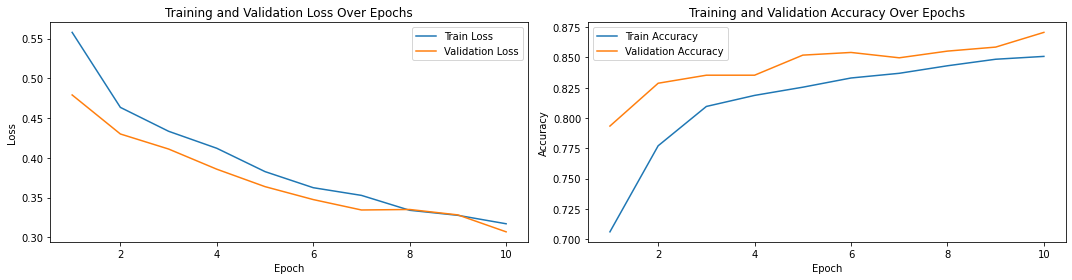

In [12]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_acc, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
# Save the model
torch.save(model.state_dict(), 'ecg_model.pth')


In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Set the model to evaluation mode
model.eval()

# Perform inference on the training dataset
with torch.no_grad():
    train_outputs = model(X_train_tensor.unsqueeze(1))

# Get predictions for training dataset
_, train_predictions = torch.max(train_outputs, 1)

# Convert predictions and ground truth to numpy arrays
train_predictions_np = train_predictions.numpy()
y_train_np = y_train_tensor.numpy()

# Calculate evaluation metrics for training dataset
train_accuracy = accuracy_score(y_train_np, train_predictions_np)
train_precision = precision_score(y_train_np, train_predictions_np)
train_recall = recall_score(y_train_np, train_predictions_np)
train_f1 = f1_score(y_train_np, train_predictions_np)
train_confusion = confusion_matrix(y_train_np, train_predictions_np)

# Perform inference on the test dataset
with torch.no_grad():
    test_outputs = model(X_test_tensor.unsqueeze(1))

# Get predictions for test dataset
_, test_predictions = torch.max(test_outputs, 1)

# Convert predictions and ground truth to numpy arrays
test_predictions_np = test_predictions.numpy()
y_test_np = y_test_tensor.numpy()

# Calculate evaluation metrics for test dataset
test_accuracy = accuracy_score(y_test_np, test_predictions_np)
test_precision = precision_score(y_test_np, test_predictions_np)
test_recall = recall_score(y_test_np, test_predictions_np)
test_f1 = f1_score(y_test_np, test_predictions_np)
test_confusion = confusion_matrix(y_test_np, test_predictions_np)

# Print the evaluation metrics
print("Training Metrics:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1 Score: {train_f1:.4f}")
print("Confusion Matrix:")
print(train_confusion)

print("\nTest Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")
print("Confusion Matrix:")
print(test_confusion)


Training Metrics:
Accuracy: 0.8835
Precision: 0.9303
Recall: 0.8527
F1 Score: 0.8898
Confusion Matrix:
[[2989  255]
 [ 588 3404]]

Test Metrics:
Accuracy: 0.8740
Precision: 0.9338
Recall: 0.8404
F1 Score: 0.8846
Confusion Matrix:
[[354  31]
 [ 83 437]]


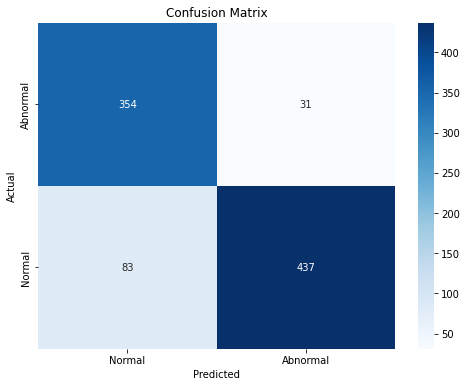

In [15]:
import seaborn as sns
conf_matrix = confusion_matrix(y_test_np, test_predictions_np)

# Define class labels
class_labels = ['Normal', 'Abnormal']

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels[::-1])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

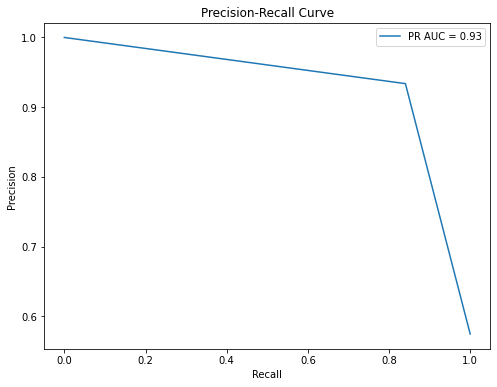

In [16]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Assuming test_predictions_np and y_test_np are your predicted and actual labels
precision, recall, thresholds = precision_recall_curve(y_test_np, test_predictions_np)

# Calculate area under the curve (AUC)
pr_auc = auc(recall, precision)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

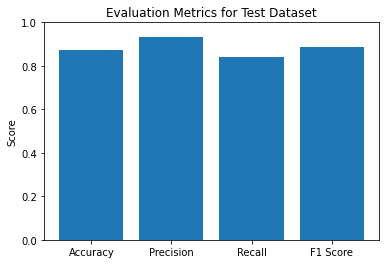

In [17]:
accuracy = accuracy_score(y_test_np, test_predictions_np)
precision = precision_score(y_test_np, test_predictions_np)
recall = recall_score(y_test_np, test_predictions_np)
f1 = f1_score(y_test_np, test_predictions_np)

# Plot the metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [accuracy, precision, recall, f1]

plt.bar(metrics, values)
plt.title('Evaluation Metrics for Test Dataset')
plt.ylabel('Score')
plt.ylim(0, 1)  # Assuming scores are between 0 and 1
plt.show()